<H2> Question - do trap catches correlate with Moon Phase? </H2>

In [414]:
import numpy as np
import pandas as pd
import salem
from salem import get_demo_file, DataLevels, GoogleVisibleMap, Map
import matplotlib.pyplot as plt
import pylunar
from datetime import date, timedelta
import scipy.stats as st
from tqdm import notebook,trange
import sklearn
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
plt.style.use('seaborn')

In [415]:
catches_df = pd.read_hdf('catches.h5',key='catches')

In [416]:
mi = pylunar.MoonInfo((-43, 31, 32), (172,38,23))

In [417]:
mi.update((2021, 7, 10, 1, 45, 0))
mi.fractional_phase()

0.0007530370363060812

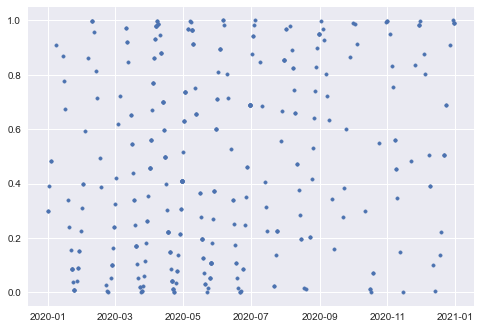

In [418]:
dt = []
phase = []
day_counts = {}
for index, row in catches_df.iterrows():
    if row['Datetime'].year == 2020 and row['Species caught'] == 'Rat':
        d = row['Datetime']
        dt.append(row['Datetime'])
        mi.update((row['Datetime'].year,row['Datetime'].month,row['Datetime'].day,0,0,0))
        phase.append(mi.fractional_phase())
        if d not in day_counts:
            day_counts[d] = 1
        else: 
            day_counts[d] += 1
        
plt.scatter(dt,phase,marker='.')
plt.show()

In [419]:
def daterange(start_date, end_date):
    for n in range(int((end_date - start_date).days)):
        yield start_date + timedelta(n)

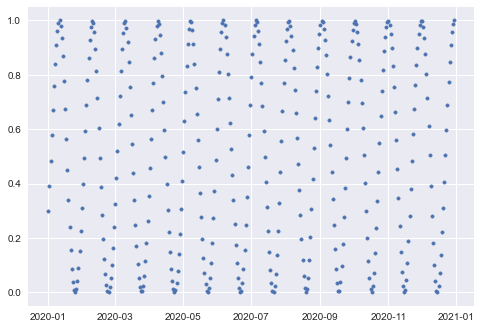

In [420]:
start_date = date(2020, 1, 1)
end_date = date(2020, 12, 31)
weekly_phase = np.zeros(54)
year_phase= []
year_dt = []
for d in daterange(start_date, end_date):
    week = ((date(d.year,d.month,d.day).timetuple().tm_yday -1) // 7) + 1
    mi.update((d.year,d.month,d.day,0,0,0))
    weekly_phase[week-1] += mi.fractional_phase()
    year_phase.append(mi.fractional_phase())
    year_dt.append(d)
    
weekly_phase /= 7.0 # Average of the week:
plt.scatter(year_dt,year_phase,marker='.')
plt.show()

No evidence of a strong correlation from this plot

Look instead at weekly counts:

In [421]:
from tqdm import notebook,trange
# Compute year counts
year_counts = {}
for i in trange(len(catches_df), ascii=True):
    year = catches_df.iloc[i]['Datetime'].year
    if year not in year_counts:
        year_counts[year] = 1
    else:
        year_counts[year] += 1
        

for y in sorted(year_counts.keys()):
    print("{} {:5d}".format(y,year_counts[y]))

100%|#####################################| 6115/6115 [00:00<00:00, 9032.15it/s]

2016     6
2017   193
2018  1348
2019  2124
2020  1777
2021   667


In [422]:
def week_of_year( dt ):
    """
    Returns the week of the year given a datetime object
    """
    return (date(dt.year,dt.month,dt.day).timetuple().tm_yday // 7) + 1
    
    
    

In [423]:
# Compute weekly counts:
def get_weekly_counts(df, species, years):
    """
    Compute the weekly counts of catches for "species" in Pandas dataframe "dr"
    Return a dictionary where the keys are the specified "years"
    and the values are arrays with counts per week
    """
    weekly_counts={}
    for y in years:
        weekly_counts[y] = np.zeros((54),dtype='int32')
     
    for i in trange(len(df), ascii=True):
        dt = df.iloc[i]['Datetime']
        if dt.year in years and df.iloc[i]['Species caught'] == species:
            week = week_of_year(dt)
            weekly_counts[dt.year][week] += 1
   

    return weekly_counts


In [424]:
# Compute weekly phases of the moon:
def get_weekly_phases( years):
    """
    Compute the average weekly phase of the moon for each of the years in the list specified
    Return a dictionary where the keys are the specified years and values are arrays of avarage 
    phase of the moon for each week of the year
    """
    mi = pylunar.MoonInfo((-43, 31, 32), (172,38,23))
    weekly_phases={}
    for y in years:
        weekly_phase = np.zeros((54),dtype='float')
        start_date = date(y, 1, 1)
        end_date = date(y, 12, 31)

        for d in daterange(start_date, end_date):
            week = week_of_year(d)
            mi.update((d.year,d.month,d.day,0,0,0))
            f =  mi.fractional_phase()
            weekly_phase[week] = weekly_phase[week] + f
            
            
        weekly_phase = weekly_phase/7.0
        weekly_phases[y] = weekly_phase.copy()
        

    return weekly_phases


In [425]:
years = [2018,2019,2020]


In [426]:
# Now compute the weekly average phase of the moon for each year:
weekly_phases = get_weekly_phases(years)


100%|#####################################| 6115/6115 [00:01<00:00, 4890.95it/s]


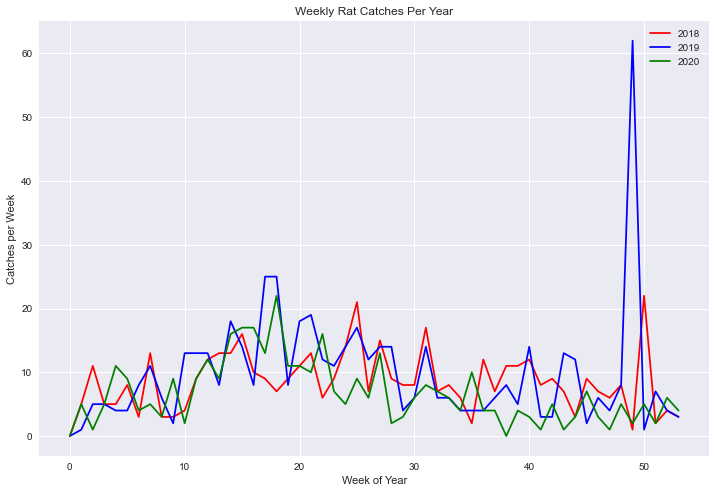

In [427]:
fig, ax = plt.subplots(figsize=(12,8))
rat_weekly_counts = get_weekly_counts(catches_df,"Rat", years)
ax.plot(rat_weekly_counts[2018], c="red", label="2018")
ax.plot(rat_weekly_counts[2019], c="blue", label="2019")
ax.plot(rat_weekly_counts[2020], c="green", label="2020")
ax.set_title("Weekly Rat Catches Per Year")
ax.set_xlabel("Week of Year")
ax.set_ylabel("Catches per Week")
ax.legend()
plt.savefig("plots/WeeklyCatchesPerYear.png")
plt.show()


<H4> Removal of Outliers </H4>
There are some clear outliers near the end of 2018 and 2019, probably due to bulk updates from other recording systems. It seems reasonable to remove thos outliers by averaging from the weeks either side of them


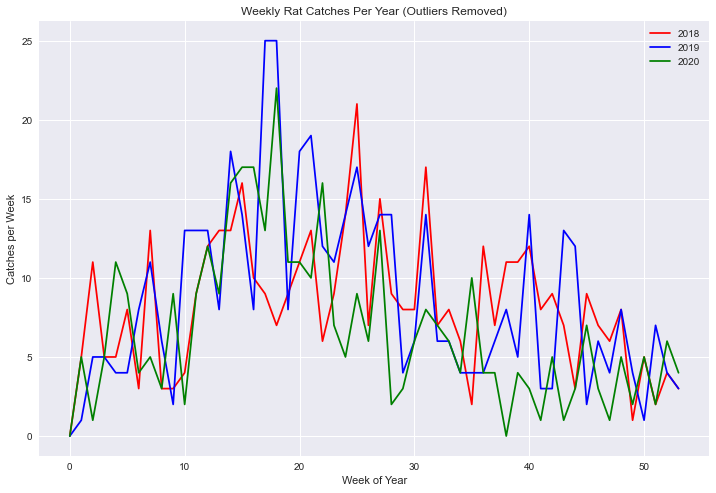

In [428]:
#Removal of Outliers:
rat_weekly_counts[2019][49] = (rat_weekly_counts[2019][48] + rat_weekly_counts[2019][50])//2
rat_weekly_counts[2018][50] = (rat_weekly_counts[2019][49] + rat_weekly_counts[2019][51])//2
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(rat_weekly_counts[2018], c="red", label="2018")
ax.plot(rat_weekly_counts[2019], c="blue", label="2019")
ax.plot(rat_weekly_counts[2020], c="green", label="2020")
ax.set_title("Weekly Rat Catches Per Year (Outliers Removed)")
ax.set_xlabel("Week of Year")
ax.set_ylabel("Catches per Week")
ax.legend()
plt.savefig("plots/WeeklyCatchesPerYear.png")
plt.show()


<H3> Rat Catches per Week vs. Phase of the Moon </H3>

In [429]:

def plot_weekly_catches_and_phase(weekly_counts, weekly_phases, year,catch_color = '#992222',phase_color = '#999999',
                                 title="", filename=None):
    """
    Plot the weekly catches and moon phase on the same plot
    """
   
    fig, ax1 = plt.subplots(figsize=(10,6))

    ln1=ax1.plot(weekly_counts[year]/max(weekly_counts[year]), color=catch_color, label="Catches")
    ax1.set_xlabel("Week of Year")
    ax1.set_ylabel("Relative Catches per Week")
    ax1.set_ylim(0,1.0)
    
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    ln2 = ax2.plot(weekly_phases[year], color=phase_color, label="Phase")
    ax2.set_ylabel("Phase of Moon")
    ax2.set_ylim(0,1.0)
    #fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.title(title)
    
    lns = ln1+ln2
    labs = [l.get_label() for l in lns]
    ax1.legend(lns, labs, loc=0)
    if filename:
        plt.savefig(filename)
    plt.show()

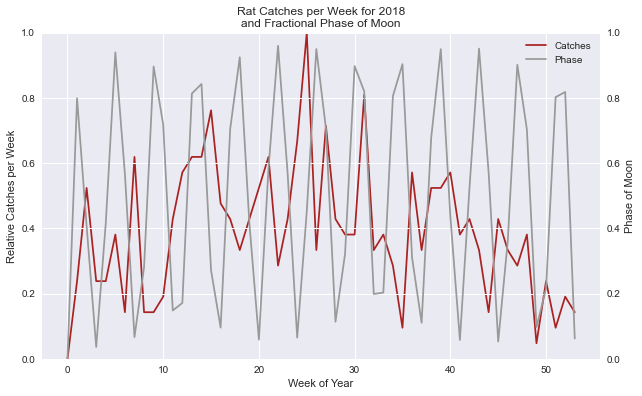

In [430]:
plot_weekly_catches_and_phase(rat_weekly_counts,weekly_phases, 2018,catch_color="#AA2222",
                              title="Rat Catches per Week for 2018\nand Fractional Phase of Moon",
                              filename="plots/rats_per_week_2018.png")

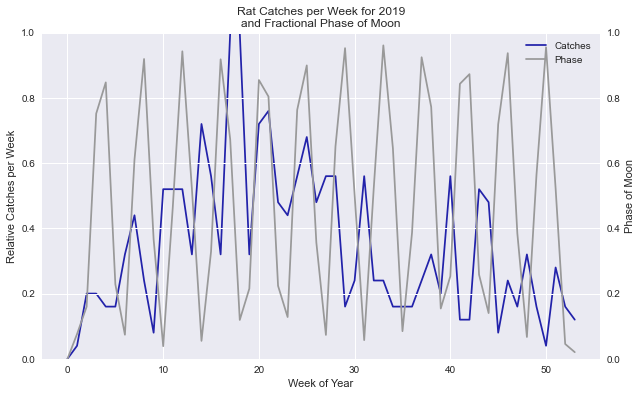

In [431]:
plot_weekly_catches_and_phase(rat_weekly_counts,weekly_phases, 2019, catch_color="#2222AA",
                              title="Rat Catches per Week for 2019\nand Fractional Phase of Moon",
                              filename="plots/rats_per_week_2019.png")

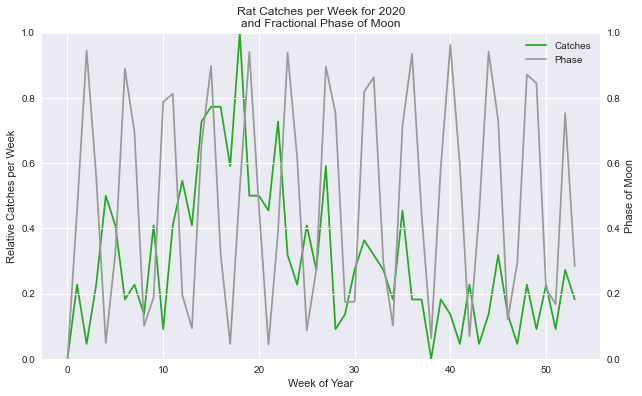

In [432]:
plot_weekly_catches_and_phase(rat_weekly_counts,weekly_phases, 2020, catch_color="#22AA22",
                              title="Rat Catches per Week for 2020\nand Fractional Phase of Moon",
                              filename="plots/rats_per_week_2020.png")

<H3> Weekly Possum Catches and the Phase of the Moon </H3>

In [433]:
possum_weekly_counts = get_weekly_counts(catches_df,"Possum", years)

100%|#####################################| 6115/6115 [00:01<00:00, 5117.70it/s]


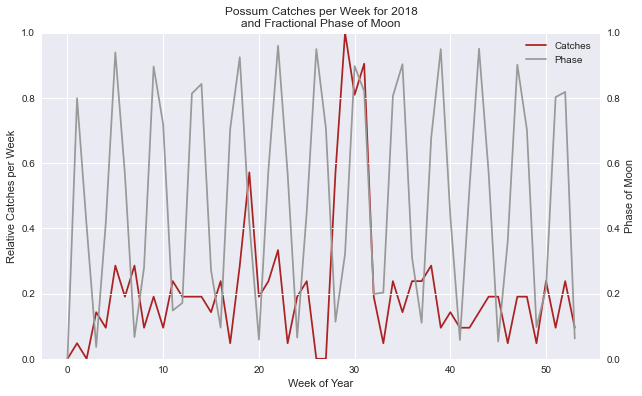

In [434]:
plot_weekly_catches_and_phase(possum_weekly_counts,weekly_phases, 2018,catch_color="#AA2222",
                              title="Possum Catches per Week for 2018\nand Fractional Phase of Moon" ,
                             filename="plots/possums_per_week_2018.png")

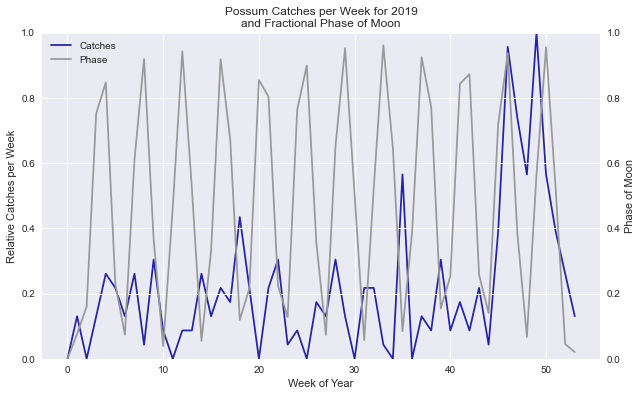

In [435]:
plot_weekly_catches_and_phase(possum_weekly_counts,weekly_phases, 2019,catch_color="#2222AA",
                              title="Possum Catches per Week for 2019\nand Fractional Phase of Moon" ,
                             filename="plots/possums_per_week_2019.png")

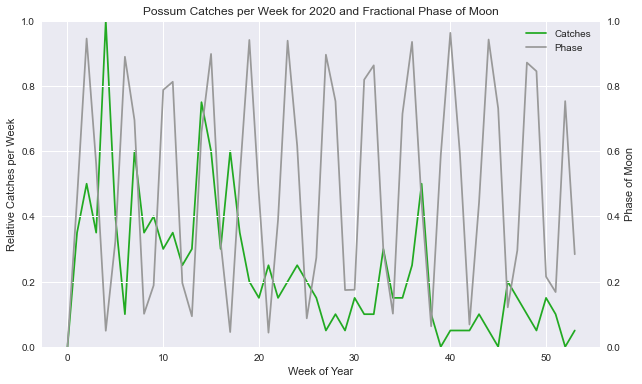

In [436]:
plot_weekly_catches_and_phase(possum_weekly_counts,weekly_phases, 2020,catch_color="#22AA22",
                              title="Possum Catches per Week for 2020 and Fractional Phase of Moon" ,
                             filename="plots/possums_per_week_2020.png")

<H2> Regression Models </H2>

Try various regression models to see if the pattern in behaviour can be captured

In [437]:
def plot_prediction(y_pred,y_test,method):
    """
    Plot prediction between y_pred and y_test for 2021 data
    """
    plt.plot(y_pred, label=method,c="#AA2222")
    plt.plot(y_test, label="Actual",c="#2222AA")
    plt.xlabel("Week of Year")
    plt.ylabel("Catches")
    plt.title("{} Prediction for 2021".format(method))
    plt.legend()
    plt.show()

In [438]:
# Combine the data from the three years:
rat_combined_weekly_counts = np.concatenate((rat_weekly_counts[2018],rat_weekly_counts[2019], rat_weekly_counts[2020]))
combined_weekly_phases = np.concatenate((weekly_phases[2018],weekly_phases[2019], weekly_phases[2020]))

#Compute the week of year:
one_week_of_year = np.arange(54)/54.0
combined_week_of_year = np.concatenate((one_week_of_year,one_week_of_year,one_week_of_year))

X = np.vstack((combined_weekly_phases,combined_week_of_year)).T
y = np.copy(rat_combined_weekly_counts).astype(float)
print("There are {} X values and {} Y values".format(len(X),len(y)))

There are 162 X values and 162 Y values


In [439]:
# Create test data based on 2021:
wp = get_weekly_phases([2021])
X_test = np.vstack((wp[2021],one_week_of_year)).T
X_test = X_test[:30]
y_test = get_weekly_counts(catches_df,"Rat",[2021])[2021]
y_test = y_test[:30]


100%|#####################################| 6115/6115 [00:00<00:00, 8432.02it/s]


<H3> Decision Tree </H3>

Score for training is 1.000


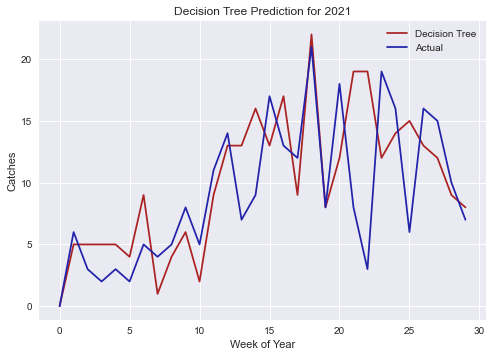

In [440]:
# Start with decision tree:
clf_tree = tree.DecisionTreeRegressor(max_depth=50)
clf_tree = clf_tree.fit(X, y)
print("Score for training is {:.3f}".format(clf_tree.score(X,y)))
y_pred_rf = regr.predict(X_test)
y_pred_tree = clf_tree.predict(X_test)
plot_prediction(y_pred_tree,y_test,"Decision Tree")

<H3> Random Forest Regressor </H3>

Score for training is 0.901


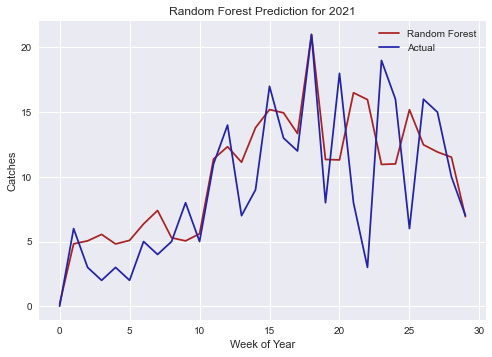

In [441]:
regr = RandomForestRegressor(max_depth=20, random_state=12002)
regr.fit(X, y)
print("Score for training is {:.3f}".format(regr.score(X,y)))
y_pred_rf = regr.predict(X_test)

plot_prediction(y_pred_rf,y_test,"Random Forest")

<H3> Scalar Vector Machine </H3>

Score for training is 0.870


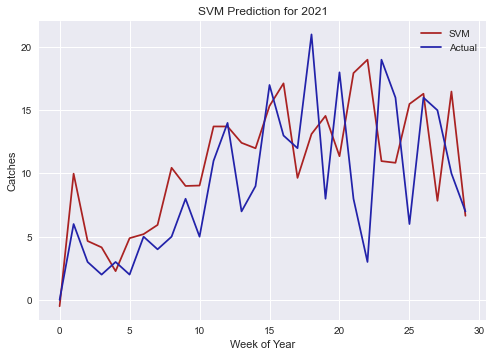

In [443]:
from sklearn import svm
regr_svm = svm.SVR(kernel='rbf', C=50, gamma=100, epsilon=.5)
regr_svm.fit(X, y)
print("Score for training is {:.3f}".format(regr_svm.score(X,y)))
y_pred_svm = regr_svm.predict(X_test)

plot_prediction(y_pred_svm,y_test,"SVM")

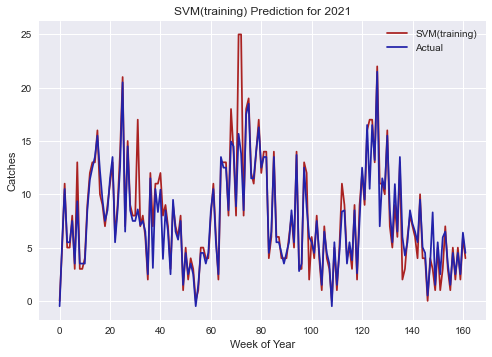

In [444]:
# Also look at training comparison:
y_train_pred_svm =  regr_svm.predict(X)
plot_prediction(y,y_train_pred_svm,"SVM(training)")

The prediction does seem to match general trends of the reported catches reasonably well but here are some
signifacnt areas where they diverge.

<H3> Considering Rainfall </H3>
What other factors might be important in terms of rat catches? One obvious issue might be rainfall/cloud cover. Historical data, at least that at now charge, seems to be quite hard to come by. Fortunately I do have rainfall data, recorded at 15 minute intervals from my own weather station. Given it's a realatively simple bucket tipping device the absolute numbers may not be reliable but the main points is just likely to know when it is raining signifcantly.

In [445]:
def remove_nans(df,col):
    before = len(df)
    df = df.dropna(subset=[col])
    after = len(df)
    print("{} rows with Nan {} values removed".format(before-after,col))
    return df

In [446]:
#Read rainfall data:
rain_df = pd.read_csv("cash_rainfall.csv")

rain_df['Datetime'] = pd.to_datetime(rain_df['Datetime'])
rain_df = remove_nans(rain_df,"rainfall")
print("There are {:5d} rows of rainfall data".format(len(rain_df)))
rain_df.head()



0 rows with Nan rainfall values removed
There are 364542 rows of rainfall data


,Datetime,rainfall
0,2017-06-08 19:34:24,0.0
1,2017-06-08 19:39:34,0.0
2,2017-06-08 19:44:45,0.0
3,2017-06-08 19:49:55,0.0
4,2017-06-08 19:55:05,0.0


In [447]:
# Compute weekly rainfall:
def get_weekly_rainfall(df, years):
    """
    Compute the weekly rainfall in Pandas dataframe "df"
    Return a dictionary where the keys are the specified "years"
    and the values are arrays with counts per week
    """
    weekly_rain={}
    for y in years:
        weekly_rain[y] = np.zeros((54),dtype='float32')
     
    for i in trange(len(df), ascii=True):
        dt = df.iloc[i]['Datetime']
        if dt.year in years:
            week = week_of_year(dt)
            weekly_rain[dt.year][week] += df.iloc[i]['rainfall'] 
   

    return weekly_rain

In [448]:
weekly_rainfall = get_weekly_rainfall(rain_df, years)

100%|#################################| 364542/364542 [01:05<00:00, 5563.78it/s]


In [449]:
def plot_weekly_catches_and_rainfall(weekly_counts, weekly_rain, year,catch_color = '#992222',rain_color = '#999999',
                                 title="", filename=None):
    """
    Plot the weekly catches and moon phase on the same plot
    """
   
    fig, ax1 = plt.subplots(figsize=(10,6))

    ln1=ax1.plot(weekly_counts[year], color=catch_color, label="Catches")
    ax1.set_xlabel("Week of Year")
    ax1.set_ylabel(" Catches per Week")
    #ax1.set_ylim(0,1.0)
    
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    ln2 = ax2.plot(weekly_rain[year], color=rain_color, label="Rain fall")
    ax2.set_ylabel("Weekly Rainfall (mm)")
    #ax2.set_ylim(0,1.0)
    #fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.title(title)
    
    lns = ln1+ln2
    labs = [l.get_label() for l in lns]
    ax1.legend(lns, labs, loc=0)
    if filename:
        plt.savefig(filename)
    plt.show()

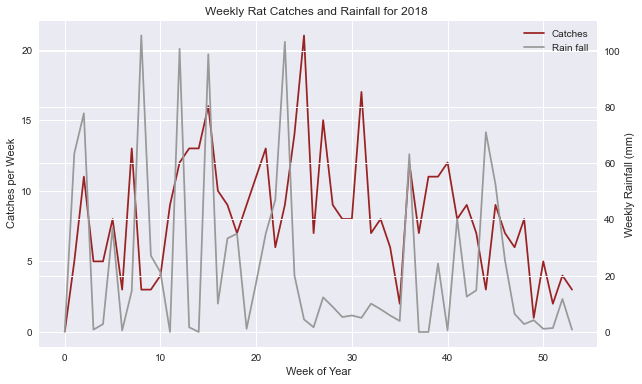

In [450]:
plot_weekly_catches_and_rainfall(rat_weekly_counts,weekly_rainfall,2018,
                                 title="Weekly Rat Catches and Rainfall for 2018 ")

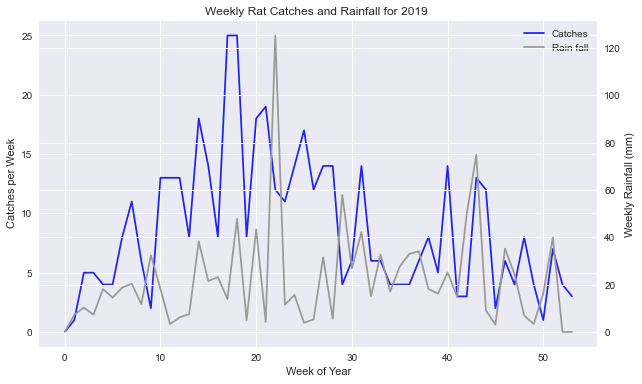

In [451]:
plot_weekly_catches_and_rainfall(rat_weekly_counts,weekly_rainfall,2019,catch_color="#2222EE",
                                 title="Weekly Rat Catches and Rainfall for 2019 ")

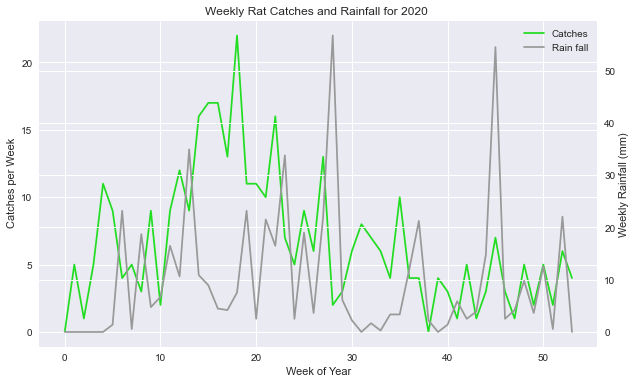

In [452]:
plot_weekly_catches_and_rainfall(rat_weekly_counts,weekly_rainfall,2020,catch_color="#22DD22",
                                 title="Weekly Rat Catches and Rainfall for 2020 ")

It's a little hard to intrepet these plots but it seems worthwhile including the rainfall data in the model to see how/if it improves the prediction

<H3> Regression Model with Rainfall Included <H3>

In [453]:
# Combine the data from the three years:
rat_combined_weekly_counts = np.concatenate((rat_weekly_counts[2018],rat_weekly_counts[2019], rat_weekly_counts[2020]))
combined_weekly_phases = np.concatenate((weekly_phases[2018],weekly_phases[2019], weekly_phases[2020]))

# Combine the weekly rainfall and scale them to relative per year:
combined_weekly_rainfall = np.concatenate(((weekly_rainfall[2018])/max(weekly_rainfall[2018]),
                                           (weekly_rainfall[2019])/max(weekly_rainfall[2019]),
                                           (weekly_rainfall[2020])/max(weekly_rainfall[2019])))
#Compute the week of year:
one_week_of_year = np.arange(54)/54.0
combined_week_of_year = np.concatenate((one_week_of_year,one_week_of_year,one_week_of_year))

X = np.vstack((combined_weekly_rainfall,combined_weekly_phases,combined_week_of_year)).T
y = np.copy(rat_combined_weekly_counts).astype(float)
print("There are {} X values and {} Y values".format(len(X),len(y)))

There are 162 X values and 162 Y values


In [454]:
# Create test data based on 2021:
wp = get_weekly_phases([2021])[2021]
rf = get_weekly_rainfall(rain_df,[2021])[2021]
rf = rf/(max(rf))
X_test = np.vstack((rf/max(rf),wp,one_week_of_year)).T
X_test = X_test[:30]
y_test = get_weekly_counts(catches_df,"Rat",[2021])[2021]
y_test = y_test[:30]


100%|#####################################| 6115/6115 [00:00<00:00, 8621.76it/s]


Score for training is 0.990


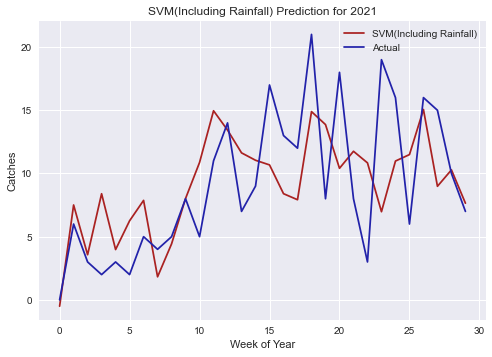

In [456]:
from sklearn import svm
regr_svm_rain = svm.SVR(kernel='rbf', C=50, gamma=100, epsilon=.5)
regr_svm_rain.fit(X, y)
print("Score for training is {:.3f}".format(regr_svm_rain.score(X,y)))
y_pred_svm_rain = regr_svm_rain.predict(X_test)

plot_prediction(y_pred_svm_rain,y_test,"SVM(Including Rainfall)")